# Survival Analysis

I first became interested in survival analysis while on a DataKind datadive where we were trying to model the churn of the users of a social enterprise's app.  It's been a while since then, but havving been mulling it over I thought it was high time to go back to basics and consider this stuff from first principles (or as close to first principles as I can stomach...)

## Ultra Basic Model

Ok, first up let's just create some dummy data of a really basic survival analysis sequence.  In this case a simple random decay model will do nicely, think the decays of a fissile atom - random but probabilistically predictable.

In [2]:
import numpy as np
import pandas as pd
import random
%matplotlib inline


decay_hist_df = pd.DataFrame()
num_atoms = 1000
decay_hist_df['t0'] = [1]*num_atoms

t=0
while t < 100:
    t+=1
    decay_seq = np.asarray([random.randint(50, 100) for x in range(0, num_atoms)])/100
    current_state = np.asarray(decay_hist_df['t' + str(t-1)])
    decay_stat = np.around(current_state * decay_seq)
    decay_hist_df['t' + str(t)] = list(decay_stat)
    

decay_hist_df.head(5)

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t91,t92,t93,t94,t95,t96,t97,t98,t99,t100
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ok so we've now got some dummy synthetic data to have a stab at.  Now in the interests of being a good DS citien the first thing I'm going to do is plot this data as a histogram, to get a sense of the decay

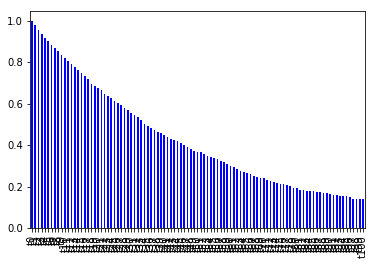

In [3]:
decay_hist_df.mean().plot(kind='bar', color = 'b')

Interesting, we can clearly see a quadratic decay function.  Now let's start using the python package lifelines to do some modelling on this:

In [4]:
import lifelines

First we need to massage the data into the correct format (the observant amongst us will notice that I could've/should've done this with the data from the start, but a bit of pandas practice never hut anyone)

In [5]:
df = pd.DataFrame()
df['event'] = list(decay_hist_df.sum())
df['t'] = list(range(len(df)))
df.head(5)

,event,t
0,1000.0,0
1,981.0,1
2,955.0,2
3,935.0,3
4,919.0,4


Ok, first up Kaplan Meier.  This is you bog standard model, not terribly sophisticated (in fact it's really just a graphical plot, like the best fit line you'd draw in school only with all the dots joined).

In [6]:
from lifelines import KaplanMeierFitter

t = df['t']
event = df['event']

kmf = KaplanMeierFitter()
kmf.fit(t, event_observed=event)


<lifelines.KaplanMeierFitter: fitted with 101 observations, 0 censored>

Ok, now we've fit the model, let's plot it out...

Median:  50.0


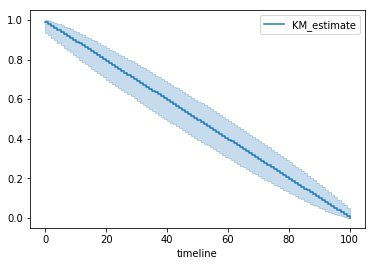

In [7]:
kmf.survival_function_
kmf.confidence_interval_
print('Median: ',kmf.median_)
kmf.plot()

Interesting thus far.  Let's take a look at some more representative data.  The lifelines package comes with some nifty ones:

In [8]:
from lifelines.datasets import load_waltons
df = load_waltons()
t = df['T']
event = df['E']


And we refit with Kaplan Meier

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(t, event_observed=event)

<lifelines.KaplanMeierFitter: fitted with 163 observations, 7 censored>

Median:  56.0


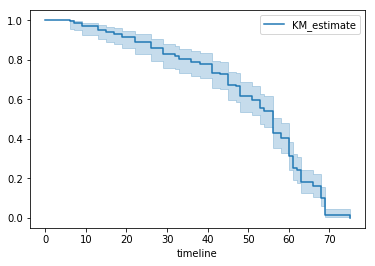

In [10]:
kmf.survival_function_
kmf.confidence_interval_
print('Median: ',kmf.median_)
kmf.plot()

Again we can see the confidence intervals wrapping the KM plot, giving us a sense of the projection quality


In [7]:
from lifelines import CoxPHFitter
df = pd.get_dummies(df)
df = df.drop(columns=['group_miR-137'],axis=1) # making for a more compact model, no extra info was/is included in this variable

cph = CoxPHFitter()
cph.fit(df,duration_col='T', event_col='E', show_progress=True)

cph.print_summary()

NameError: name 'pd' is not defined

Ok, so let's examine this; the warning is pretty prescient, with the group_control dimension dictating the outcomes.  We can see this backed up by the coefficient estimated by the model, that is -2.05 and a z score which is well within the significant boundary (presumed to be 0.05 given stats' dirty little 1 in 20 secret).  The stats also give us an opportunity to calcualte a BIC score, a neat and super simple (though for now admittedly redundant, given no competing models) way to measure model quality.  The calculation is as follows

$BIC Score = ln(n)k - 2ln(Likelihood)$

where n is the data set size and k is the number of parameters (1 in the case above)


In [12]:
import math
def BIC(n,k,twoll):
    BIC_score = 2* math.log(n)*k + twoll
    return BIC_score
print("BIC Score",BIC(163,1,68.14))

BIC Score 78.32750040161352


## Improvements...

So far we've only looked at a single, uber simple, model.  Time to get more into the thick of it.  !st off, let's get ourselves a more complex data set

In [4]:
from lifelines.datasets import load_rossi

rossi_dataset = load_rossi()

In [5]:
rossi_dataset.head(5)

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


That's more like it... Now let's analyse, but time to stick with a Cox Proportional Hazards model

In [8]:
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.50881, step_size = 0.9500, ll = -675.38063, newton_decrement = 16.76434, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.13852, step_size = 0.9500, ll = -659.79004, newton_decrement = 0.99157, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01802, step_size = 0.9500, ll = -658.76197, newton_decrement = 0.01422, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00108, step_size = 1.0000, ll = -658.74771, newton_decrement = 0.00005, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -658.74766, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.75
  time fit was run = 2019-04-19 21:13:15 UTC

---
      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper

So, we can see with some certainty that the 'prio', 'fin' and 'age' dimensions have a significant negative relationship with survival, with thre rest being non significant.  Worth noting that fin is only JUST in the significance marker and hence a sliver of p hacking could be in play (if we were reporting these results to ruthless academics).  Now let's look at the BIC score...

In [9]:
print("BIC Score", BIC(432,7,15.37))

NameError: name 'BIC' is not defined

Not so fast - let's look at the assumptions shall we.  The proportional hazard bit of the model is very important (basically that as time progresses the hazards remain proportionate to one another, imagine a scenario where being a start up increases the likelihood of default in the first 5 years, but after that becomes irrelavant, that's a non proportional hazard )

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.09 <0.005     10.17
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.16
mar  km              0.60   0.44      1.19
    

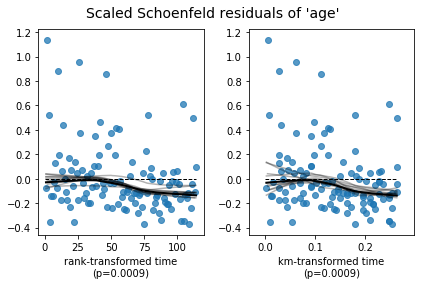

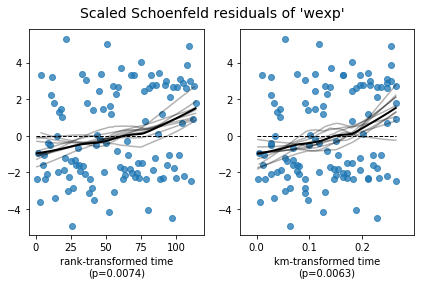

In [20]:
cph.check_assumptions(rossi_dataset, p_value_threshold=0.05, show_plots=True)

Not good... This can also be done brute force by looking at the KM plots, but taht's basically what the results above.  Time to try out some of the tips - let's bin the age feature, pd.cut is recommended but some pretty standard maths works nicely too

In [15]:
rossi_dataset['age'] = round(rossi_dataset['age']/10)*10

and time to refit

In [16]:
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest', show_progress=True)

cph.print_summary()

Iteration 1: norm_delta = 0.48070, step_size = 0.9500, ll = -675.38063, newton_decrement = 14.60170, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.10133, step_size = 0.9500, ll = -662.50302, newton_decrement = 0.73210, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.01165, step_size = 0.9500, ll = -661.74697, newton_decrement = 0.00930, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00067, step_size = 1.0000, ll = -661.73766, newton_decrement = 0.00003, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -661.73762, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -661.74
  time fit was run = 2019-04-19 21:15:48 UTC

---
      coef exp(coef)  se(coef)     z      p  -log2(p)  lower 0.95  upper

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.

<lifelines.StatisticalResult>
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km              8.44 <0.005      8.09
     rank            8.53 <0.005      8.16
fin  km              0.01   0.91      0.14
     rank            0.01   0.91      0.13
mar  km              0.35   0.55      0.86
    

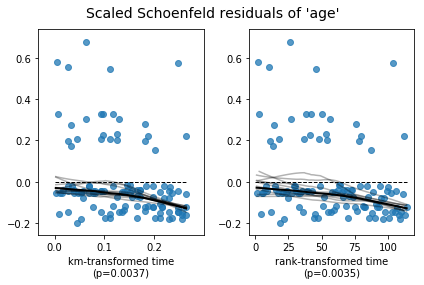

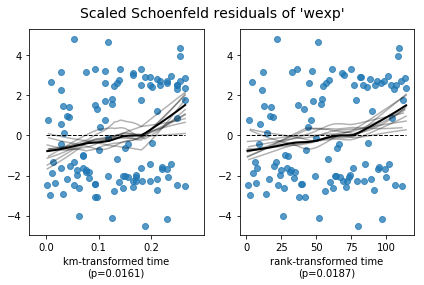

In [17]:
cph.check_assumptions(rossi_dataset, p_value_threshold=0.05, show_plots=True)

Still problems, but there is potentially some improvement (if you squint), with some loss of the sin-ish curve pattern.  Depending on the needs this might be ok, but it's far from ideal

## Conclusion

So we've examined some data with some pretty standard techniques getting a KM plot and a Cox PH too.  Assumptions suggest that perhaps this is not the best option for modelling so we should look to some different models; next up... Accelerated Failure Times